In [33]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import face_recognition
from scipy.spatial import distance

import warnings
warnings.filterwarnings('ignore')

In [37]:
def highlight_facial_points(image_path):
    # load the image
    image_bgr = cv2.imread(image_path)
    # convert from bgr to rgb
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # detect faces in the image
    face_locations = face_recognition.face_locations(image_rgb, model='cnn')

    for face_location in face_locations:
        # get facial landmarks
        landmarks = face_recognition.face_landmarks(image_rgb, [face_location])[0]

        # Iterate over the facial landmarks and draw them on the image
        for landmark_type, landmark_points in landmarks.items():
            for (x, y) in landmark_points:
                cv2.circle(image_rgb, (x, y), 3, (0, 255, 0), -1)

    # plot the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

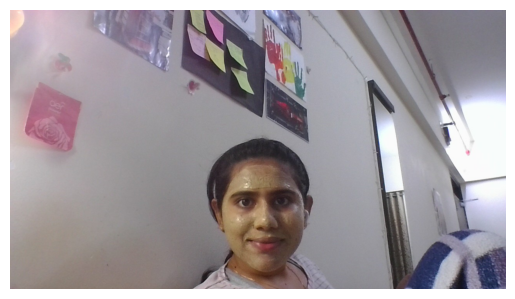

In [34]:
image_path = r"C:\Users\naushaba imroz\OneDrive\Pictures\Camera Roll\test.JPG"
image = Image.open(image_path)
plt.axis('off')
plt.imshow(image)
plt.show()

In [45]:
def highlight_facial_points(image_path):
    # load the image
    image_bgr = cv2.imread(image_path)
    # convert from bgr to rgb
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # detect faces in the image
    face_locations = face_recognition.face_locations(image_rgb, model='hog')

    for face_location in face_locations:
        # get facial landmarks
        landmarks = face_recognition.face_landmarks(image_rgb, [face_location])[0]

        # Iterate over the facial landmarks and draw them on the image
        for landmark_type, landmark_points in landmarks.items():
            for (x, y) in landmark_points:
                cv2.circle(image_rgb, (x, y), 3, (0, 255, 0), -1)

    # plot the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()
    

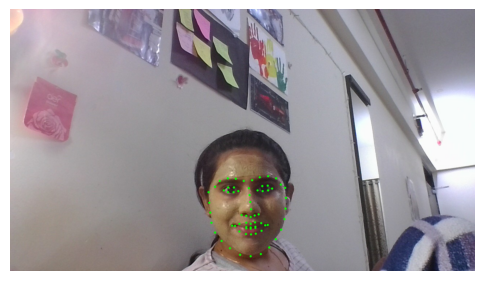

In [46]:
highlight_facial_points(image_path)

In [47]:
# calculate eye aspect ratio
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A+B) / (2.0 * C)
    return ear

# calculate mount aspect ratio
def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[2], mouth[10])
    B = distance.euclidean(mouth[4], mouth[8])
    C = distance.euclidean(mouth[0], mouth[6])
    mar = (A+B) / (2.0 * C)
    return mar

In [48]:
def process_image(frame):
    # define thresholds
    EYE_AR_THRESH = 0.25
    MOUTH_AR_THRESH = 0.6

    if frame is None:
        raise ValueError('Image is not found or unable to open')

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # find all face locations
    face_locations = face_recognition.face_locations(rgb_frame)

    # initiate flags
    eye_flag = mouth_flag = False

    for face_location in face_locations:
        # extract facial landmarks
        landmarks = face_recognition.face_landmarks(rgb_frame, [face_location])[0]
        # extract eye and mouth coordinates
        left_eye = np.array(landmarks['left_eye'])
        right_eye = np.array(landmarks['right_eye'])
        mouth = np.array(landmarks['bottom_lip'])

        # calculate ear and mar
        left_ear = eye_aspect_ratio(left_eye)
        right_ear = eye_aspect_ratio(right_eye)
        ear = (left_ear+right_ear) / 2.0
        mar = mouth_aspect_ratio(mouth)

        # check if eyes are closed
        if ear < EYE_AR_THRESH:
            eye_flag = True

        # check if yawning
        if mar > MOUTH_AR_THRESH and eye_flag==True:
            mouth_flag = True

    return eye_flag, mouth_flag


In [54]:
img = cv2.imread(image_path)
process_image(img)

(False, False)

In [55]:
import cv2

video_cap = cv2.VideoCapture(0)  # Open webcam
count = score = 0

while True:
    ret, frame = video_cap.read()
    if not ret:
        break  # Exit if the webcam is not detected

    cv2.imshow("Webcam Feed", frame)  # Show the webcam feed

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break  # Press 'q' to exit

video_cap.release()
cv2.destroyAllWindows()


In [56]:
import cv2
import face_recognition
import numpy as np

# Start webcam
video_cap = cv2.VideoCapture(0)

while True:
    ret, frame = video_cap.read()
    if not ret:
        break  # Exit if webcam is not detected

    # Convert frame from BGR (OpenCV format) to RGB (face_recognition format)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Detect face locations
    face_locations = face_recognition.face_locations(rgb_frame, model='hog')

    # Detect facial landmarks
    face_landmarks_list = face_recognition.face_landmarks(rgb_frame, face_locations)

    # Draw facial landmarks
    for landmarks in face_landmarks_list:
        for landmark_type, points in landmarks.items():
            for (x, y) in points:
                cv2.circle(frame, (x, y), 2, (0, 255, 0), -1)  # Green dots on landmarks

    # Show the processed video feed
    cv2.imshow("Face Detection with Landmarks", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release resources
video_cap.release()
cv2.destroyAllWindows()


In [6]:
import cv2
import face_recognition
import numpy as np
from scipy.spatial import distance
import time
import winsound

# --- Thresholds and Constants ---
EYE_AR_THRESH = 0.25
MOUTH_AR_THRESH = 0.6
DROWSINESS_TIME = 5  # seconds
FLASH_INTERVAL = 0.5  # seconds
BRIGHTNESS_THRESHOLD = 15  # for blocked camera
FACE_NOT_FOUND_TIME = 3  # seconds
CAMERA_DISCONNECTED_TIME = 3  # seconds

# --- Timers ---
drowsiness_start_time = None
flash_start_time = None
face_not_found_time = None
camera_disconnected_time = None

# --- EAR Calculator ---
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    return (A + B) / (2.0 * C)

# --- MAR Calculator ---
def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[2], mouth[10])
    B = distance.euclidean(mouth[4], mouth[8])
    C = distance.euclidean(mouth[0], mouth[6])
    return (A + B) / (2.0 * C)

# --- Start Camera ---
video_cap = cv2.VideoCapture(0)
if not video_cap.isOpened():
    while True:
        error_frame = np.zeros((480, 640, 3), dtype=np.uint8)
        error_frame[:] = (0, 0, 255)
        cv2.putText(error_frame, "CAMERA NOT FOUND!", (100, 240),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 3)
        # No beep for CAMERA NOT FOUND
        cv2.imshow("Drowsiness & Motion Detection", error_frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    exit()

while True:
    ret, frame = video_cap.read()
    if not ret or frame is None:
        if camera_disconnected_time is None:
            camera_disconnected_time = time.time()
        elif time.time() - camera_disconnected_time >= CAMERA_DISCONNECTED_TIME:
            frame[:] = (0, 0, 255)
            cv2.putText(frame, "CAMERA DISCONNECTED!", (100, 240),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 3)
            winsound.Beep(1000, 500)  # Beep once to indicate disconnection
        cv2.imshow("Drowsiness & Motion Detection", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
        continue

    camera_disconnected_time = None  # Reset timer if camera is connected

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray_frame)
    face_locations = face_recognition.face_locations(rgb_frame)

    # --- If Camera is Blocked ---
    if brightness < BRIGHTNESS_THRESHOLD:
        frame[:] = (0, 0, 255)
        cv2.putText(frame, "CAMERA BLOCKED!", (100, 240),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.1, (255, 255, 255), 3)
        winsound.Beep(1000, 400)
        cv2.imshow("Drowsiness & Motion Detection", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
        continue  # Skip other checks when camera is blocked

    # --- Face Not Found (Only when camera is not blocked) ---
    if len(face_locations) == 0:
        if face_not_found_time is None:
            face_not_found_time = time.time()
        elif time.time() - face_not_found_time >= FACE_NOT_FOUND_TIME:
            frame[:] = (0, 0, 255)
            cv2.putText(frame, "FULL FACE NOT FOUND!", (100, 240),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.1, (255, 255, 255), 3)
            winsound.Beep(1000, 500)
    else:
        face_not_found_time = None  # Reset timer if face is found

    # --- Drowsiness + Yawning Detection ---
    if len(face_locations) > 0:
        for face_location in face_locations:
            landmarks = face_recognition.face_landmarks(rgb_frame, [face_location])[0]
            left_eye = np.array(landmarks['left_eye'])
            right_eye = np.array(landmarks['right_eye'])
            mouth = np.array(landmarks['bottom_lip'])

            left_ear = eye_aspect_ratio(left_eye)
            right_ear = eye_aspect_ratio(right_eye)
            ear = (left_ear + right_ear) / 2.0
            mar = mouth_aspect_ratio(mouth)

            # --- Drowsiness Detection ---
            if ear < EYE_AR_THRESH:
                if drowsiness_start_time is None:
                    drowsiness_start_time = time.time()
                elif time.time() - drowsiness_start_time >= DROWSINESS_TIME:
                    frame[:] = (0, 0, 255)
                    cv2.putText(frame, "DROWSINESS WARNING!", (80, 240),
                                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 3)

                    if flash_start_time is None or time.time() - flash_start_time >= FLASH_INTERVAL:
                        winsound.Beep(1000, 400)
                        flash_start_time = time.time()
            else:
                drowsiness_start_time = None
                flash_start_time = None

            # --- Yawning Detection ---
            if mar > MOUTH_AR_THRESH and ear < EYE_AR_THRESH:
                cv2.putText(frame, "YAWNING DETECTED!", (30, 100),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 255, 255), 3)

    # --- Show Final Frame ---
    cv2.imshow("Drowsiness & Motion Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# --- Cleanup ---
video_cap.release()
cv2.destroyAllWindows()
